<a href="https://colab.research.google.com/github/tejasbana/Style-Transfer-Pytorch/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style transfer

Using Pre-trained VGG network and extracting features for style transfer in Pytorch

In [ ]:
from torchvision import models
from torchvision import transforms
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, max_size=None, shape=None):
    """Load an image and convert it to a torch tensor."""
    # image = Image.open(image_path)
    image = Image.open(image_path).convert('RGB')
    
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform:
        image = transform(image).unsqueeze(0)
    
    return image.to(device)


class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


def main(content,style):
    
    max_size = 1024
    total_step = 2000
    log_step=10
    sample_step=500
    style_weight=100
    lr=0.003
    total_style_loss = []
    total_content_loss = []

    # Image preprocessing
    # VGGNet was trained on ImageNet where images are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    # We use the same normalization statistics here.
    transform = transforms.Compose([
        transforms.CenterCrop(400),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                             std=(0.229, 0.224, 0.225))])
    
    # Load content and style images
    # Make the style image same size as the content image
    content = load_image(content, transform, max_size=max_size)
    # style = load_image(style, transform, shape=[content.size(2), content.size(3)])
    style = load_image(style, transform, max_size=max_size)
    
    # Initialize a target image with the content image
    target = content.clone().requires_grad_(True)
    
    optimizer = torch.optim.Adam([target], lr=lr, betas=[0.5, 0.999])
    vgg = VGGNet().to(device).eval()
    
    for step in range(total_step):
        
        # Extract multiple(5) conv feature vectors
        target_features = vgg(target)
        content_features = vgg(content)
        style_features = vgg(style)

        style_loss = 0
        content_loss = 0
        for f1, f2, f3 in zip(target_features, content_features, style_features):
            # Compute content loss with target and content images
            content_loss += torch.mean((f1 - f2)**2)

            # Reshape convolutional feature maps
            _, c, h, w = f1.size()
            f1 = f1.view(c, h * w)
            f3 = f3.view(c, h * w)

            # Compute gram matrix
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())

            # Compute style loss with target and style images
            style_loss += torch.mean((f1 - f3)**2) / (c * h * w) 
        
        # Compute total loss, backprop and optimize
        loss = content_loss + style_weight * style_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_style_loss.append(style_loss.item())
        total_content_loss.append(content_loss.item())

        if (step+1) % log_step == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
                   .format(step+1, total_step, content_loss.item(), style_loss.item()))

        if (step+1) % sample_step == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

    return total_style_loss, total_content_loss

In [ ]:
content = './photo.png'
style = './style_image.jpg'
style_loss , content_loss = main(content, style)

Text(0.5, 1.0, 'Content loss VS Epoch')

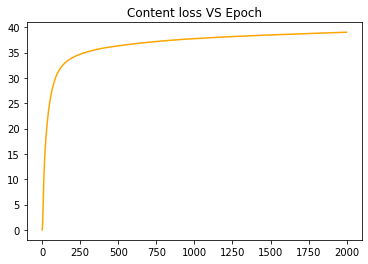

In [ ]:
import matplotlib.pyplot as plt

plt.plot(content_loss, 'orange')
plt.title("Content loss VS Epoch")

Text(0.5, 1.0, 'Style loss VS Epoch')

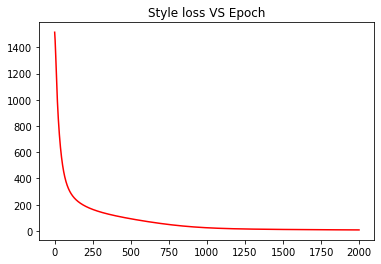

In [ ]:
plt.plot(style_loss, 'red')
plt.title("Style loss VS Epoch")